<a href="https://colab.research.google.com/github/suhyeon0325/TIL/blob/main/laidd/MOFA_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경 설정 및 필요 패키지 설치/로딩
- 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- 패키지 설치

In [ ]:
!pip install mofapy2  # MOFA(Multi-Omics Factor Analysis) 모델을 Python에서 사용
!pip install scanpy  # 단일세포 RNA-seq 데이터 분
!pip install muon  # 다중오믹스 데이터를 통합하고 분석
!pip install numpy
!pip install pandas
!pip install mofax  # MOFA 모델 결과 시각화 및 해석

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.7/293.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa

# 데이터 불러오기
- CLL_metadata.tsv: CLL 샘플 정보
- Drugs.csv: 샘플별 약물 반응 정보
- Methylation.csv: 샘플별 methylation 프로파일
- mRNA.csv: 샘플별 유전자 발현 프로파일
- Mutations.csv: 샘플별 유전자 변이 정보  (1 or 0의 binary matrix)

In [ ]:
# 데이터 폴더 위치
data_dir = "/content/drive/MyDrive/bioinformatics/ML AI 기반 유전체-단백체 멀티오믹스 통합분석 방법론/6강 실습자료"

# CLL_metadata 로딩
obs = pd.read_csv(f"{data_dir}/CLL_metadata.tsv", sep="\t", index_col="sample")

# 다른 실습 데이터를 로딩 후 scanpy의 AnnData 객체 생성
mods = {i:sc.AnnData(pd.read_csv(f"{data_dir}/{i}.csv", index_col=0).T) for i in ("Drugs", "Methylation", "mRNA", "Mutations")}


In [ ]:
print(obs.shape)
print(obs.head())

(200, 8)
       Gender        age       TTT       TTD treatedAfter   died  IGHV  \
sample                                                                   
H005        m  75.265753  0.574949  2.625599         True  False   1.0   
H006        m        NaN       NaN       NaN          NaN    NaN   NaN   
H007        f        NaN       NaN       NaN          NaN    NaN   NaN   
H008        m        NaN       NaN       NaN          NaN    NaN   NaN   
H010        f  72.780822  2.932238  2.932238        False  False   0.0   

        trisomy12  
sample             
H005          0.0  
H006          NaN  
H007          NaN  
H008          NaN  
H010          0.0  


In [ ]:
for key, adata in mods.items():
  print(f"\n{key} 데이터:")
  print("Shape:", adata.shape)  # 데이터의 차원 출력
  print("Observations (샘플):", adata.obs_names[:5])  # 샘플명
  print("Variables (특성):", adata.var_names[:5])  # 특성명
  print("Data (첫 5x5 값):")
  print(adata.X[:5, :5])  # 실제 데이터 값 (최소 행렬일 경우 변환 필요)


Drugs 데이터:
Shape: (200, 310)
Observations (샘플): Index(['H045', 'H109', 'H024', 'H056', 'H079'], dtype='object')
Variables (특성): Index(['D_001_1', 'D_001_2', 'D_001_3', 'D_001_4', 'D_001_5'], dtype='object')
Data (첫 5x5 값):
[[0.02363938 0.04623274 0.31874706 0.82370272 0.89627769]
 [0.073599   0.10623002 0.2732891  0.71713794 0.88500034]
 [       nan        nan        nan        nan        nan]
 [0.0581393  0.09022028 0.23221452 0.72257364 0.79574966]
 [0.02042077 0.04750543 0.36389622 0.80739074 0.87948865]]

Methylation 데이터:
Shape: (200, 4248)
Observations (샘플): Index(['H045', 'H109', 'H024', 'H056', 'H079'], dtype='object')
Variables (특성): Index(['cg10146935', 'cg26837773', 'cg17801765', 'cg13244315', 'cg06181703'], dtype='object')
Data (첫 5x5 값):
[[ 1.81108585 -5.17257225  5.41152631 -0.11882508  5.12038376]
 [-3.99750846  1.59487016  5.41269253  1.04387064  1.27948028]
 [-2.84431298  0.16117049  0.36570594 -4.21923622  0.7211004 ]
 [-3.33865611 -2.09343256  0.37363417 -1.59219648 

- 각 데이터의 타입을 하나의 객체 (MuData)로 통합

In [ ]:
# mods 딕셔너리에 저장된 데이터("Drugs", "Methylation", "mRNA", "Mutations")를 MuData 객체로 통합
# MuData: muon의 핵심 데이터 구조 - AnnData 객체를 통합하여 다중오믹스 분석지원
mdata = mu.MuData(mods)

/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
# muon의 기본 설정 변경 - 하나의 데이터를 수정해도 다른 데이터나 공통 메타데이터에 영향을 미치지 않음
mu.set_options(pull_on_update=False)

In [ ]:
# 각 모달리티에 공통적으로 적용되는 메타데이터 (obs)를 mdata에 저장
mdata.obs = mdata.obs.join(obs)

In [ ]:
mdata

MuData object with n_obs × n_vars = 200 × 9627
  obs:	'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV', 'trisomy12'
  4 modalities
    Drugs:	200 x 310
    Methylation:	200 x 4248
    mRNA:	200 x 5000
    Mutations:	200 x 69

# Integrate data
CLL 데이터셋에서 일부 샘플이 특정 모달리티에 없는 경우, muon으로 처리 가능함. 두 가지 모드 중 하나 선택해야 함:
1. use_obs='union': 모든 샘플의 합집합 사용. 특정 모달리티에 없는 샘플은 결측값(NA)으로 사용
2. use_obs='intersection:' 모든 모달리티에서 공통적으로 존재하는 샘플, 교집합 샘플만 사용함.

**Multi-omics factor analysis (MOFA)** integration can be run on a MuData object with a single command:

In [ ]:
# n_factors : # of factors
# convergence_mode : 모델 수렴 기준 ('medium' : 모델 학습 속도와 정확성 간 균형을 맞춘 모드)
mu.tl.mofa(mdata, use_obs='union',
           n_factors=10, convergence_mode='medium',
           outfile="models/CLL_union.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='Drugs' group='group1' with N=200 samples and D=310 features...
Loaded view='Methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='mRNA' group='group1' with N=200 samples and D=5000 features...
Loaded view='Mutations' group='group1' with N=200 samples and D=69 features...


Model options:
- Automatic Relevance Determination prior on the f

# Interpret integrated data

In [ ]:
# 모델 정의
model = mofa.mofa_model("models/CLL_union.hdf5")

In [ ]:
model

MOFA+ model: CLL union
Samples (cells): 200
Features: 9627
Groups: group1 (200)
Views: Drugs (310), Methylation (4248), Mutations (69), mRNA (5000)
Factors: 10
Expectations: W, Z

- Z (공통 factor) 추출: 샘플 간의 공통 패턴(잠재 요인)을 확인하기 위함

In [ ]:
Z = model.get_factors()
print(Z.shape)

(200, 10)


- 각 view에 대한 W (weight) 추출: 모델이 사용한 각 오믹스 데이터(views)를 확인

In [ ]:
views = model.get_views()
print(views)

['Drugs', 'Methylation', 'mRNA', 'Mutations']


In [ ]:
W_mRNA = model.get_weights(views = "mRNA")
W_Drugs = model.get_weights(views = "Drugs")
W_Methyl = model.get_weights(views="Methylation")
W_Mut = model.get_weights(views="Mutations")

print(W_mRNA.shape)
print(W_Drugs.shape)
print(W_Methyl.shape)
print(W_Mut.shape)

(5000, 10)
(310, 10)
(4248, 10)
(69, 10)


- MOFA+ 모델의 $R^2$를 시각화:
  - $R^2$ 값이 클수록 → 해당 모달리티(View)가 MOFA 모델에서 설명하는 분산이 크다는 의미
  - 즉, 모델이 데이터를 얼마나 잘 설명하는지 평가하는 중요한 지표

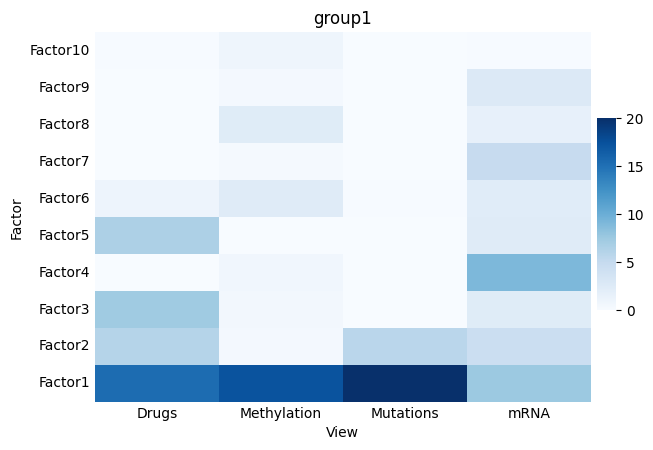

In [ ]:
mofa.plot_r2(model, x='View', vmax=20)

- Factor 1 → 모든 오믹스 데이터를 공통적으로 설명하는 요인
- Factor 3, 5 → 특정 모달리티(예: 약물 반응)와 강하게 연관된 요인
- Factor 4 → 특정 모달리티(mRNA)에서만 영향을 미치는 요인

- Weights Correlation: 가중치 행렬(W)의 요인 간 상관계수 계산
  - W 행렬(Feature × Factor)의 상관계수를 계산하고 시각화
  - W 행렬은 각 feature(유전자, 돌연변이, 약물 반응 등)가 특정 요인(factor)과 얼마나 관련이 있는지 나타냄

<Axes: >

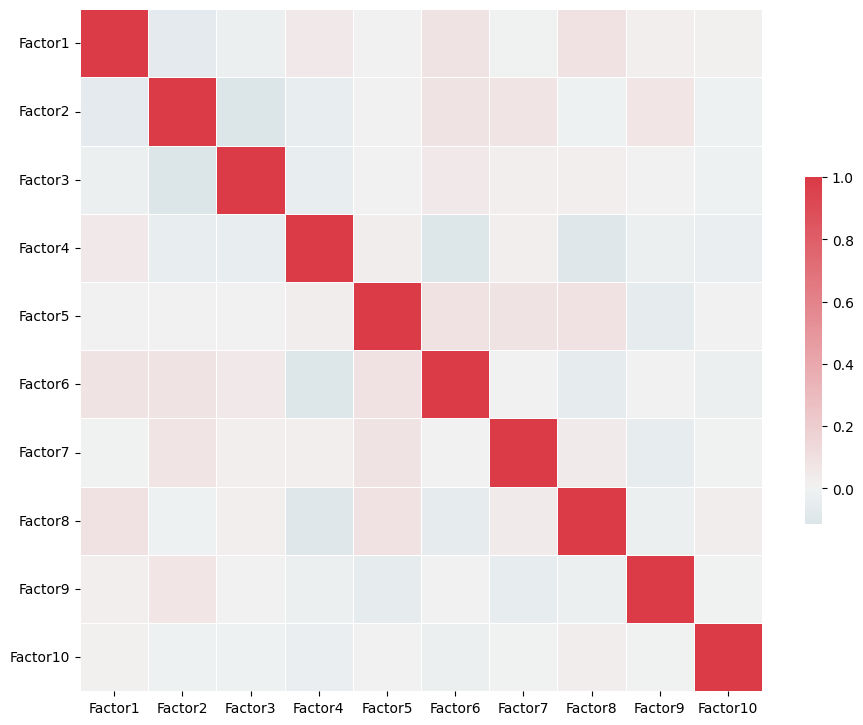

In [ ]:
mofa.plot_weights_correlation(model)

다른 factor 간의 상관관계가 매우 낮으므로 각 factor가 독립적으로 작용하며, 서로 다른 데이터 패턴을 설명하고 있음

# Plot feature weights
- Weights 해석: 특징(feature)과 요인(factor) 간 관계
  - weights는 각 featrue가 각 요인에 얼마나 기여하는지 스코어를 나타냄
  - 0에 가까운 값: 해당 요인과 관련 없는 특징
  - 절대값이 큰 값: 해당 요인과 강하게 관련된 특징
  - w>0: 해당 feature가 요인과 양의 상관관계 (positive association)
  - w<0: 해당 feature가 요인과 음의 상관관계 (negative association)

특정 feature가 특정 요인과 강하게 연결된다면, 해당 feature가 중요한 바이오마커 후보가 될 수 있음

### Weights 상위 feature 시각화 (가중치 정렬)

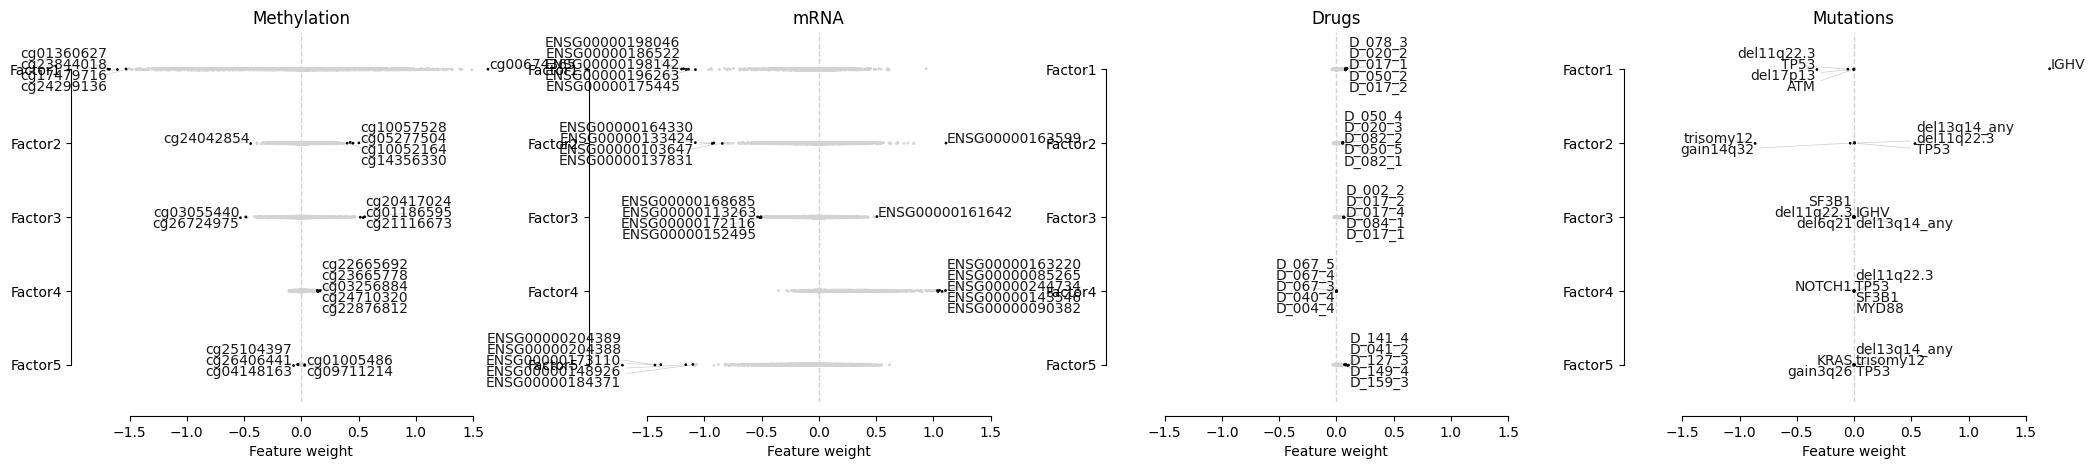

In [ ]:
ax = mofa.plot_weights(model, n_features=5, factors = range(0, 5), label_size=10)

### Weights Heatmap: 특징(feature)과 요인의 관계를 히트맵으로 시각화
특정 요인이 특정 feature와 얼마나 강하게 연결되는지 시각적으로 확인

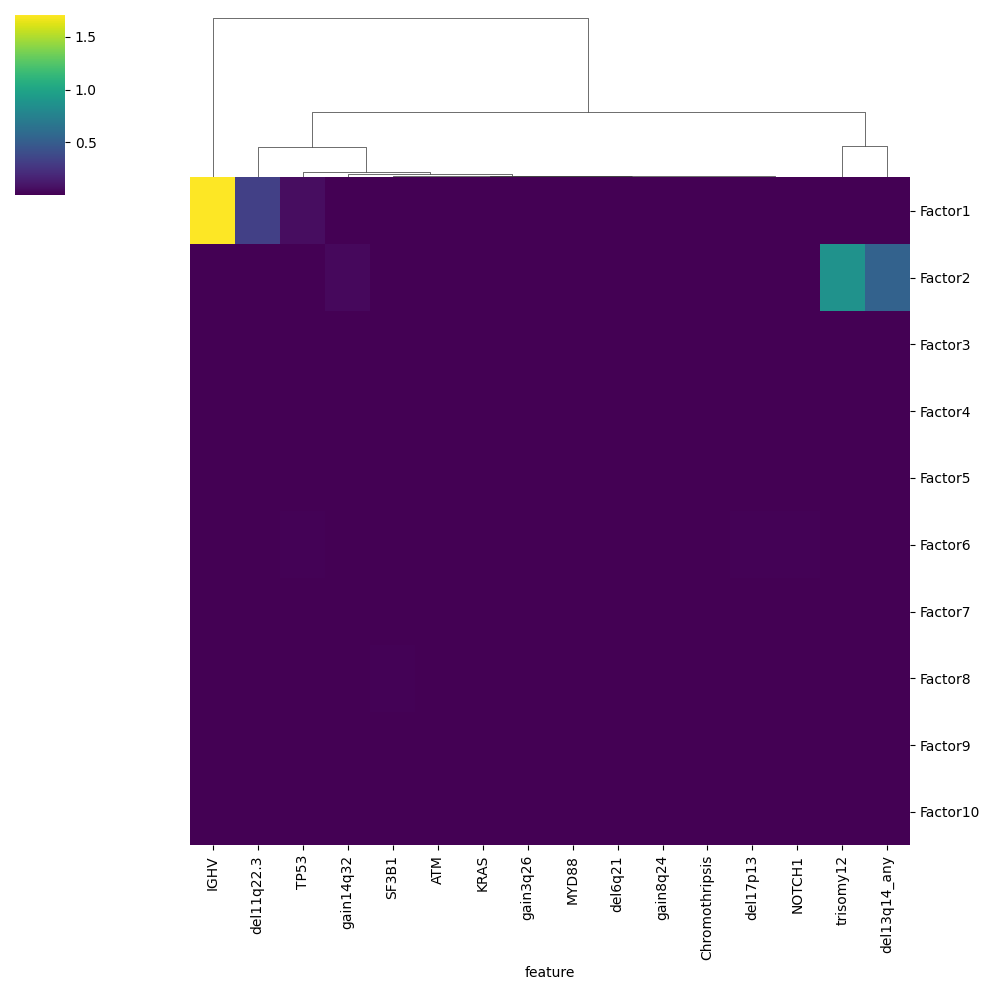

In [ ]:
mofa.plot_weights_heatmap(model, n_features=5, factors=range(0,10), w_abs=True, cmap='viridis', cluster_factors=False, view=["Mutations"])

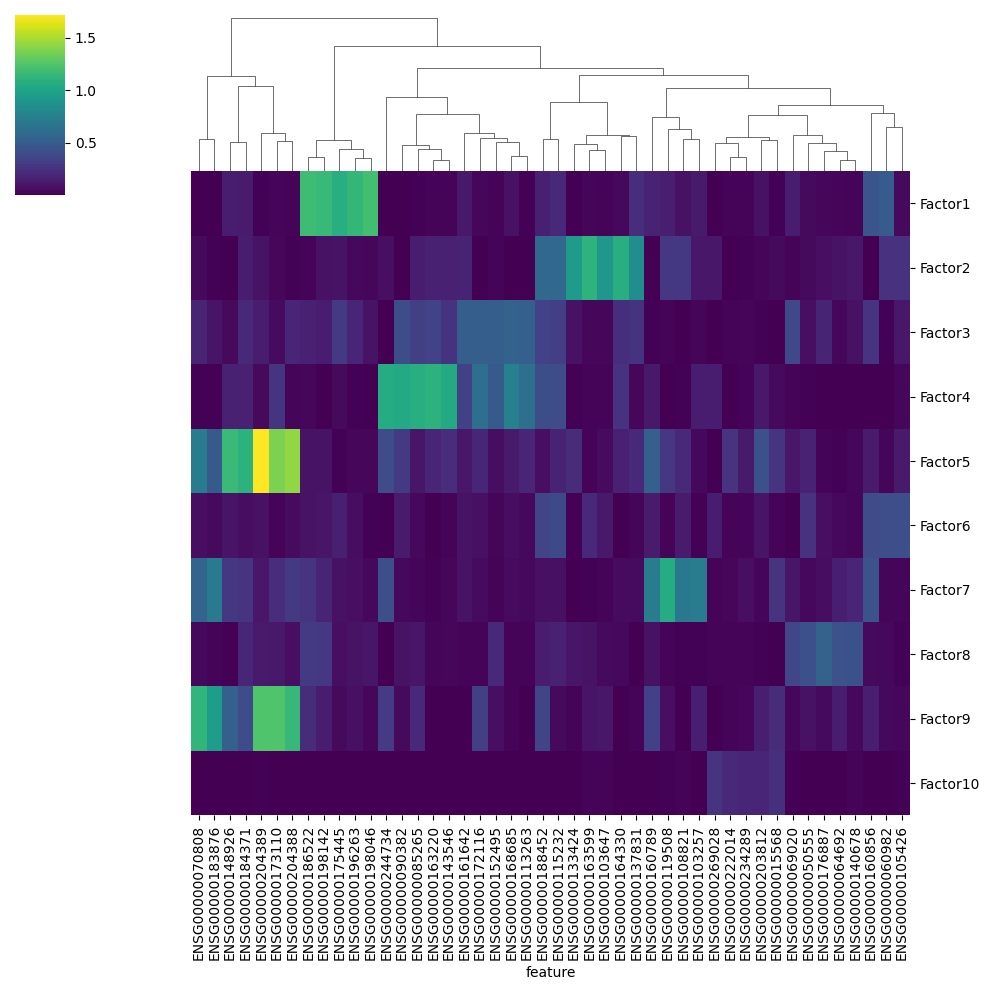

In [ ]:
mofa.plot_weights_heatmap(model, n_features=5, factors=range(0,10), w_abs=True, cmap='viridis', cluster_factors=False, view=["mRNA"])

### Weights scatterplot with mutation information
- 공통 factor를 이용한 차원 축소 2D 그림 및 mutation 상태

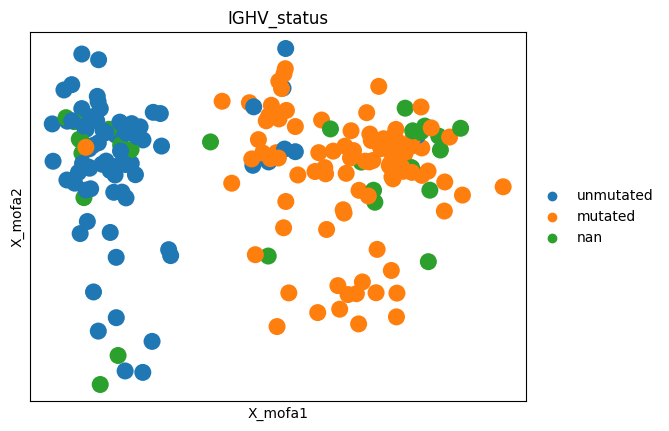

In [ ]:
# IGHV 돌연변이 상태를 범주형 변수로 변환
mdata.obs['IGHV_status'] = mdata.obs['IGHV'].astype(str).astype("category").cat.rename_categories({"1.0":"mutated", "0.0":"unmutated"})
mu.pl.mofa(mdata, color="IGHV_status")

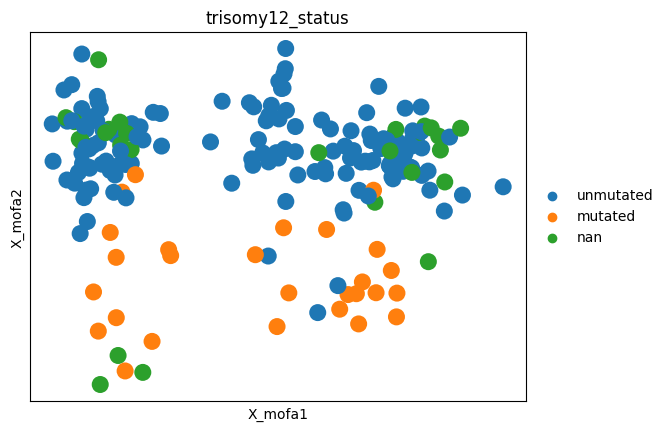

In [ ]:
# Trisomy12 상태를 범주형 변수로 변환
mdata.obs['trisomy12_status'] = mdata.obs['trisomy12'].astype(str).astype("category").cat.rename_categories({"1.0":"mutated", "0.0":"unmutated"})
mu.pl.mofa(mdata, color="trisomy12_status")

변이에 다라 샘플이 분리된다면 -> MOFA 요인이 변이와 연관된 생물학적 차이/유전자 발현 패턴을 잘 반영한 것임

### Factor 1
분산 설명 그래프 (variance explained plot)을 보면, 요인 (Facotr 1)이 모든 데이터 모달리티에서의 변화를 포착하고 있음

<Axes: title={'center': 'Mutations'}, xlabel='Feature weight'>

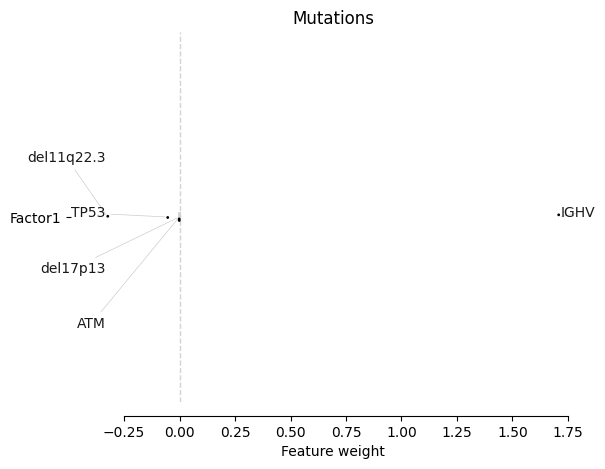

In [ ]:
mofa.plot_weights(model, views=['Mutations'], factors=0, zero_line=True, ncols=2, label_size=10)

대부분의 feature 가중치는 0 근처에 위치, 즉 대부분의 돌연변이는 Factor 1과 관련성이 없음.
하지만 IGHV(immunoglobulin heavy chain variable region) 는 유일하게 Factor 1과 강한 연관성을 보임.

**IGHV는 CLL(만성 림프구성 백혈병, Chronic Lymphocytic Leukemia)의 주요 임상 바이오마커임.**

<Axes: title={'center': 'mRNA'}, xlabel='Feature weight'>

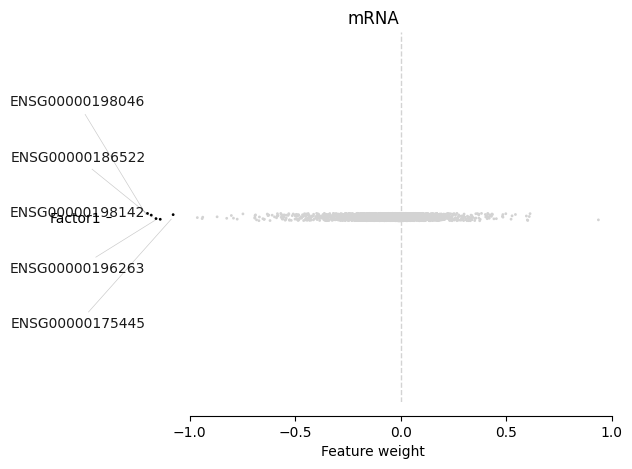

In [ ]:
mofa.plot_weights(model, views=['mRNA'], factors=0, zero_line=True, ncols=1, label_size=10)

Factor 1에서 높은 가중치를 가지는 mRNA 유전자 목록:

1. ENSG00000198046 (ZNF667)
  - lnc‐ZNF667‐AS1 유전자는 생존율과 관련이 있으며, 예후 바이오마커로 유망함.
2. ENSG00000186522 (SEPT10)
  - 이 유전자의 발현 수준은 IGHV 상태와 상관관계가 있음.
  - 하지만 IGHV와의 연관성에는 몇 가지 한계(caveats)가 존재.
3. ENSG00000198142 (SOWAHC)
  - 다른 암에서 예후 바이오마커로 확인된 유전자.

<Axes: title={'center': 'Drugs'}, xlabel='Feature weight'>

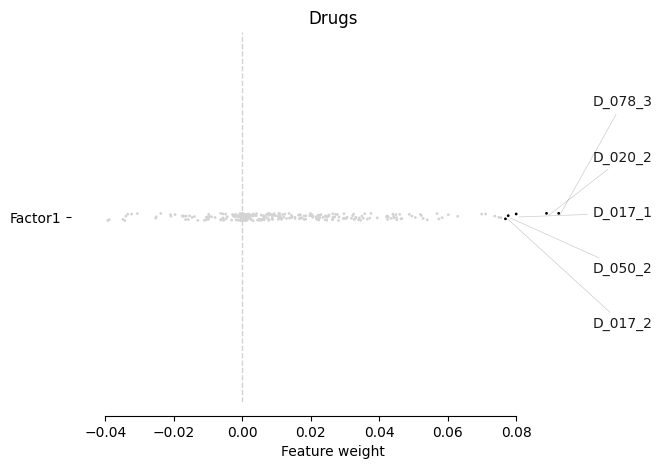

In [ ]:
mofa.plot_weights(model, views=['Drugs'], factors=0, label_size=10)

Factor 1과 높은 연관성을 가진 약물:

- PF477736 (D_078)
- AZD7762 (D_020)
- AT13387 (D_017)
- Dasatinib (D_050)

이 약물들은 IGHV 상태와 강하게 연관된 약물들로, 원래 연구에서도 같은 결과가 보고됨.
즉, Factor 1이 IGHV 변이 상태와 관련된 약물 반응을 포착하고 있음.

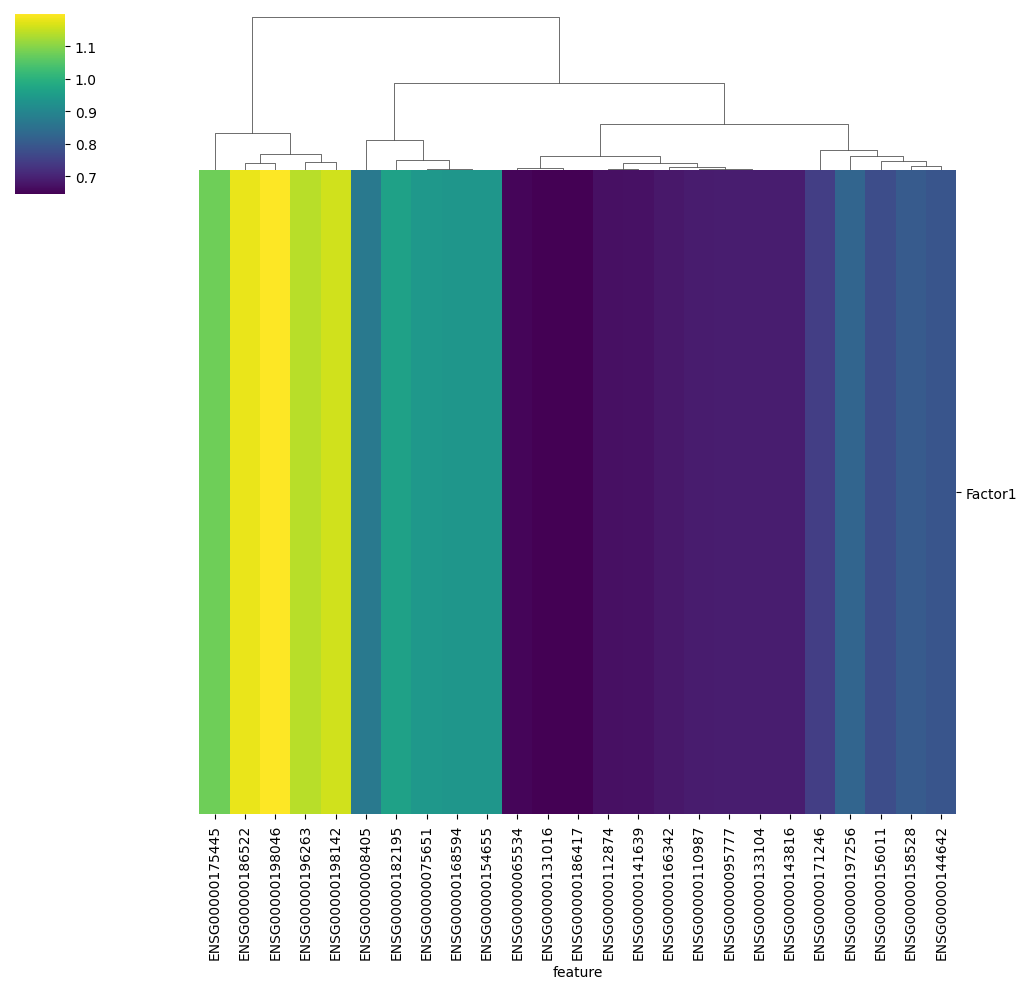

In [ ]:
mofa.plot_weights_heatmap(model, n_features=25,  factors=0, w_abs=True, cmap='viridis', cluster_factors  = False, view=["mRNA"])

### Factor 2

<Axes: title={'center': 'Mutations'}, xlabel='Feature weight'>

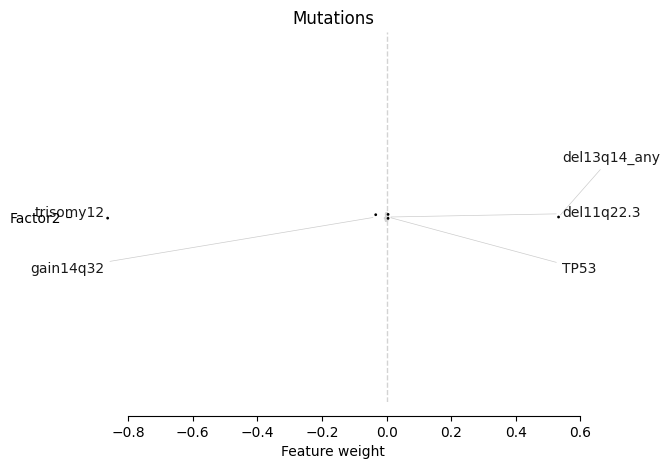

In [ ]:
mofa.plot_weights(model, views=['Mutations'], factors=1, label_size=10)

Factor 2는 돌연변이(Mutations) 데이터에서 활성화되어 있으므로, Factor 2가 특정 돌연변이와 강하게 연관되어 있을 가능성이 높음.

두 개의 주요 돌연변이가 큰 가중치를 가지며, 그중 하나는 염색체 12번 삼염색체(trisomy 12) 변이임 -> Trisomy 12는 CLL에서 두 번째로 중요한 임상 바이오마커

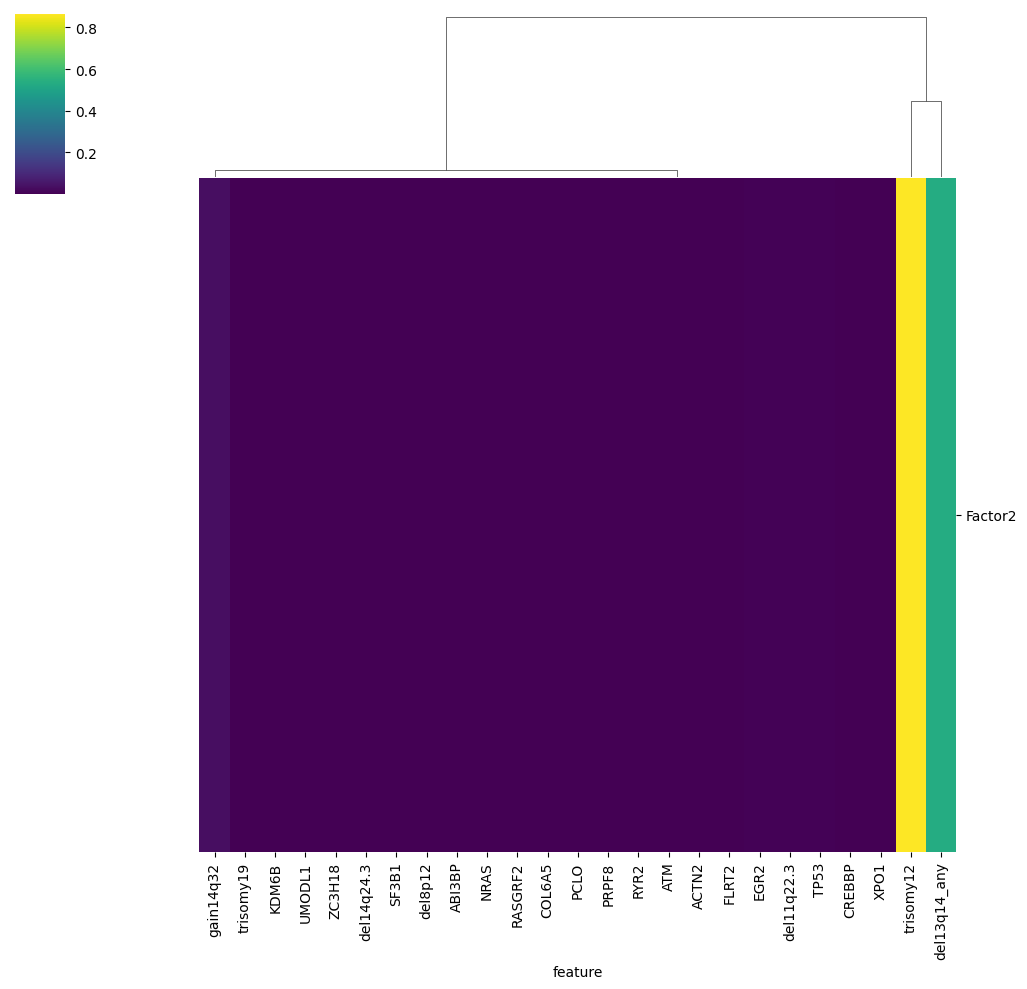

In [ ]:
mofa.plot_weights_heatmap(model, n_features=25,  factors=1, w_abs=True, cmap='viridis', cluster_factors  = False, view=["Mutations"])

### Factor 4

<Axes: title={'center': 'mRNA'}, xlabel='Feature weight'>

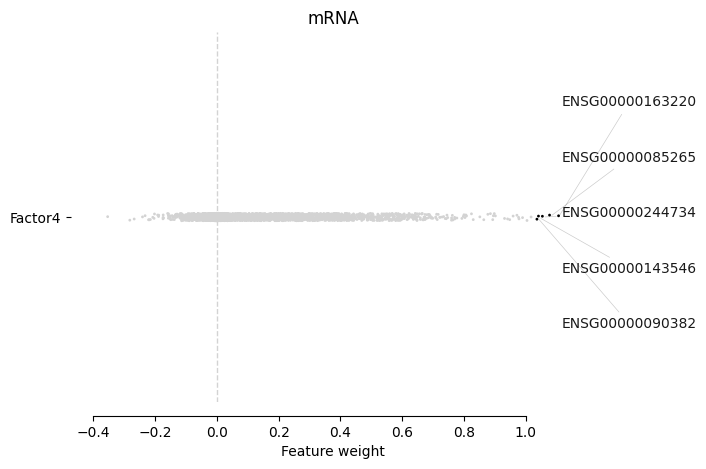

In [ ]:
mofa.plot_weights(model, views=['mRNA'], factors="Factor4", label_size=10)

Factor 4에서 높은 가중치를 가지는 유전자 목록:

1. ENSG00000163220 (S100A9)
  - 급성 골수성 백혈병(AML, Acute Myeloid Leukemia)에서 높은 발현을 보이는 유전자
  - CLL에서도 관련성이 있는 것으로 보임
2. ENSG00000085265 (FCN1)
  - AML과 연관된 유전자이며, 바이오마커 후보로 고려됨
3. ENSG00000143546 (S100A8)
  - S100A9과 동일한 기능을 하는 유전자
4. ENSG00000090382 (LYZ)
  - 골수 분화(Myeloid Differentiation) 마커

Factor 4는 골수성 백혈병(AML)과 관련된 유전자 발현 패턴을 반영할 가능성이 있지만, 현재 보유한 임상 데이터로 이를 완전히 입증하기 어렵다는 한계점이 있음.

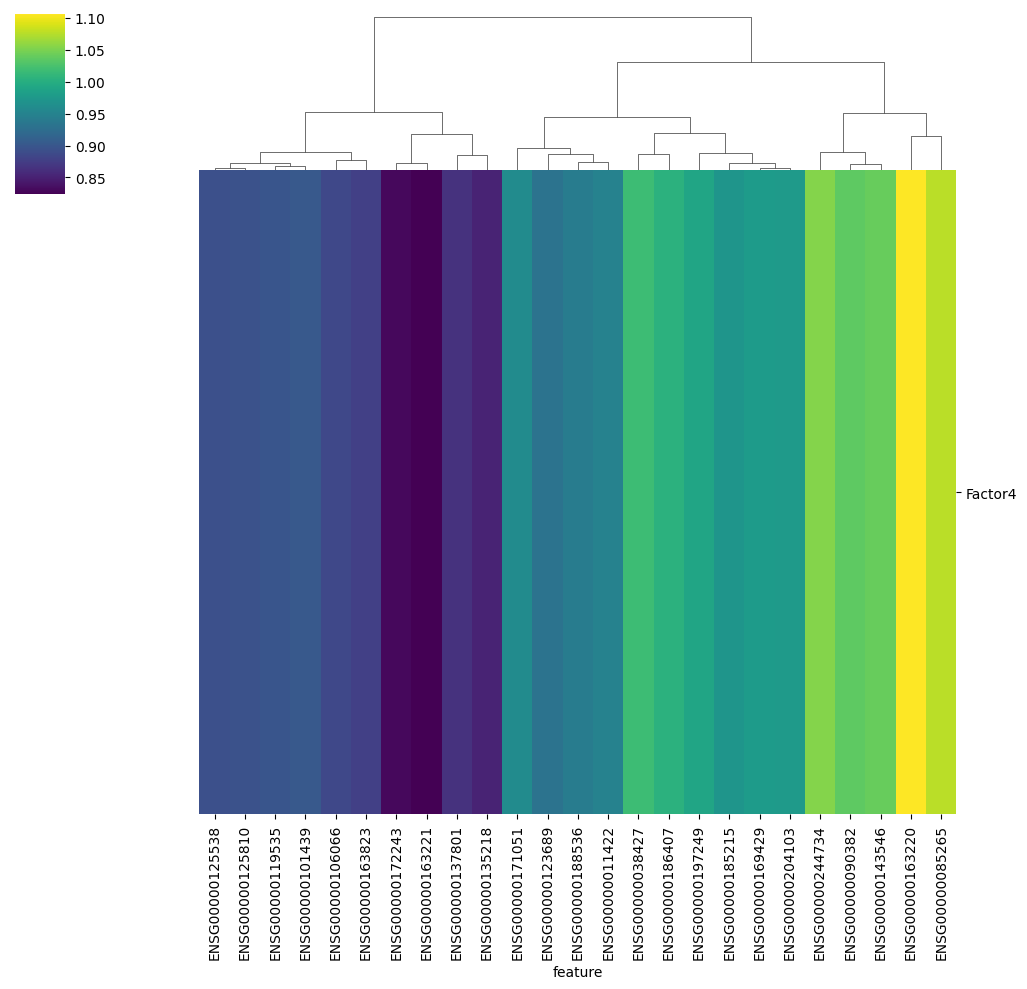

In [ ]:
mofa.plot_weights_heatmap(model, n_features=25,  factors=3, w_abs=True, cmap='viridis', cluster_factors  = False, view=["mRNA"])